*Ordinary kriging a AQMS*

In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
from pykrige.ok import OrdinaryKriging
from pykrige.uk import UniversalKriging
from shapely.geometry import Point, Polygon
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import descartes
import math
import matplotlib.colors as mcolors
import pyproj
import folium

In [2]:
# Setting
wdir = "/Users/weiha/Documents/bits/dades/Hands-on_Downscaling/Data_python/"
crs_latlon = 'EPSG:4326'  # WGS84
crs_utm = "EPSG:32631"   # UTM zone 31

In [3]:
############################################################
# Step 1: Load observation and model data
############################################################

# Load necessary datasets
sp_model = gpd.read_file(f"{wdir}sp_rawmodel_20220101.geojson")
sp_obs_locations = gpd.read_file(f"{wdir}sp_obs_locations.geojson")
df_obs = gpd.read_file(f"{wdir}obs_20220101.geojson")
domain_polygon = gpd.read_file(f"{wdir}def_domini_bcn.geojson")
refined_grid = gpd.read_file(f"{wdir}def_refined_grid_sf_100.geojson")
traffic_buffers = gpd.read_file(f"{wdir}traffic_buffers_100_class_OTM.geojson")
sp_obs_locations['geometry'] = gpd.points_from_xy(sp_obs_locations['lon'], sp_obs_locations['lat'], crs=crs_utm)

In [12]:
# Now, convert all spatial objects to UTM (EPSG:25831)
sp_model = sp_model.to_crs(crs_utm)


In [13]:
############################################################
# Step 2: Interpolate raw model to AQMS's locations
############################################################

# Pick 1000 random points for variogram fitting
np.random.seed(1)
pick_random_points = np.random.choice(len(sp_model), size=min(1000, len(sp_model)), replace=False)
input_data_example = sp_model.iloc[pick_random_points]


Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'gaussian' Variogram Model
Partial Sill: 63.80866833057113
Full Sill: 74.78609789658876
Range: 40946.73313663047
Nugget: 10.977429566017632 



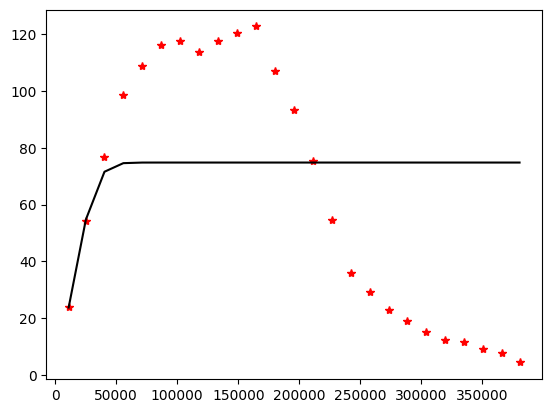

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



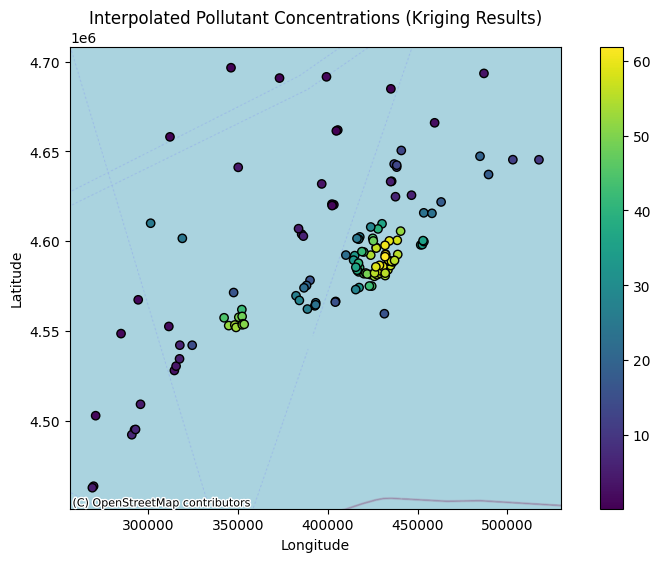

In [14]:
############################################################
# Step 3: Perform Ordinary Kriging using pykrige
############################################################

ok = OrdinaryKriging(
    input_data_example.geometry.x, input_data_example.geometry.y, input_data_example['pollutant'].values,
    variogram_model='gaussian',
    verbose=True, 
    enable_plotting=False,
    nlags=25
)

# Perform the interpolation
z, ss = ok.execute('points', sp_obs_locations.geometry.x, sp_obs_locations.geometry.y)

# Add results to the observation locations GeoDataFrame
sp_obs_locations['kriging_prediction'] = z
sp_obs_locations['kriging_variance'] = ss

sp_obs_locations_webmercator = sp_obs_locations.to_crs(epsg=3857)

# Plotting the Kriging results
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sp_obs_locations.plot(column='kriging_prediction', ax=ax, legend=True, cmap='viridis', edgecolor='k')

# Add contextily basemap (Web Mercator)
import contextily as ctx
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Add title and labels
ax.set_title('Interpolated Pollutant Concentrations (Kriging Results)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.show()

In [34]:
# Create a copy and convert to the correct CRS for folium (WGS84)
sp_obs_locations_wgs84 = sp_obs_locations.copy().to_crs(epsg=4326)

# Extract lat and lon for folium
sp_obs_locations_wgs84['lon'] = sp_obs_locations_wgs84.geometry.x
sp_obs_locations_wgs84['lat'] = sp_obs_locations_wgs84.geometry.y

# Create a colormap
norm = mcolors.Normalize(vmin=sp_obs_locations_wgs84['kriging_prediction'].min(), vmax=sp_obs_locations_wgs84['kriging_prediction'].max())
cmap = plt.cm.viridis

# Create a folium map centered around the data
map_center = [sp_obs_locations_wgs84['lat'].mean(), sp_obs_locations_wgs84['lon'].mean()]
m = folium.Map(location=map_center, zoom_start=12)

# Add circle markers for each observation location with color based on kriging prediction
for idx, row in sp_obs_locations_wgs84.iterrows():
    color = mcolors.to_hex(cmap(norm(row['kriging_prediction'])))
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=5,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=f"Pollutant: {row['kriging_prediction']:.2f}"
    ).add_to(m)

# Save the map to an HTML file and display it
#m.save('map.html')
m


In [15]:
############################################################
# Step 3: Regrid the model for Barcelona domain
############################################################

# Clip sp_model geometries using intersection with domain_polygon
sp_model_bcn = sp_model.copy()
# Combine all geometries in domain_polygon using unary_union to get a single geometry
domain_polygon_union = domain_polygon.unary_union

C:\Users\weiha\AppData\Local\Temp\ipykernel_25752\2341521609.py:8: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  domain_polygon_union = domain_polygon.unary_union


In [16]:
# Perform containment check: select geometries within the combined domain_polygon
sp_model_bcn = sp_model[sp_model['geometry'].apply(lambda geom: geom.within(domain_polygon_union))]


In [17]:
# Similarly, clip refined_grid geometries using intersection with domain_polygon
refined_grid_bcn = refined_grid.copy()
refined_grid_bcn = refined_grid[refined_grid['geometry'].apply(lambda geom: geom.within(domain_polygon_union))]



In [35]:
############################################################
# Step 2: Interpolate raw model to AQMS's locations
############################################################

# Seleccionar 1000 puntos aleatorios del modelo para ajustar el variograma
np.random.seed(1)
pick_random_points = np.random.choice(len(sp_model_bcn), size=min(1000, len(sp_model_bcn)), replace=False)
input_data_example = sp_model_bcn.iloc[pick_random_points]

In [24]:
# Convertir al CRS proyectado para operaciones geométricas
refined_grid_bcn = refined_grid_bcn.to_crs(epsg=32631)

# Calcular los centroides de las celdas recortadas (en CRS proyectado)
refined_grid_bcn['centroid'] = refined_grid_bcn.geometry.centroid

# Convertir nuevamente al CRS geográfico para visualización
refined_grid_bcn_wgs84 = refined_grid_bcn.to_crs(epsg=4326)

In [33]:
# Suponiendo que domain_polygon tiene EPSG:32631
sp_obs_locations = sp_obs_locations.to_crs(epsg=32631)
domain_polygon = domain_polygon.to_crs(epsg=32631)

# Filtrar estaciones dentro de domain_polygon
sp_obs_locations_bcn = sp_obs_locations[sp_obs_locations.geometry.within(domain_polygon.unary_union)]

C:\Users\weiha\AppData\Local\Temp\ipykernel_25752\2420851850.py:6: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  sp_obs_locations_bcn = sp_obs_locations[sp_obs_locations.geometry.within(domain_polygon.unary_union)]


In [36]:
############################################################
# Step 3: Perform Ordinary Kriging using pykrige
############################################################

# Configurar y ajustar Kriging Ordinario
ok = OrdinaryKriging(
    input_data_example.geometry.x,
    input_data_example.geometry.y,
    input_data_example['pollutant'].values,
    variogram_model='gaussian',
    verbose=True,
    enable_plotting=False,
    nlags=25
)

# Ejecutar la interpolación en las ubicaciones de las estaciones de observación
z, ss = ok.execute('points', sp_obs_locations.geometry.x, sp_obs_locations.geometry.y)

# Agregar los resultados de Kriging al GeoDataFrame de observaciones
sp_obs_locations['kriging_prediction'] = z
sp_obs_locations['kriging_variance'] = ss

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'gaussian' Variogram Model
Partial Sill: 200.1111270795367
Full Sill: 200.1111270795368
Range: 5949.939863226686
Nugget: 1.2481982796934714e-13 

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



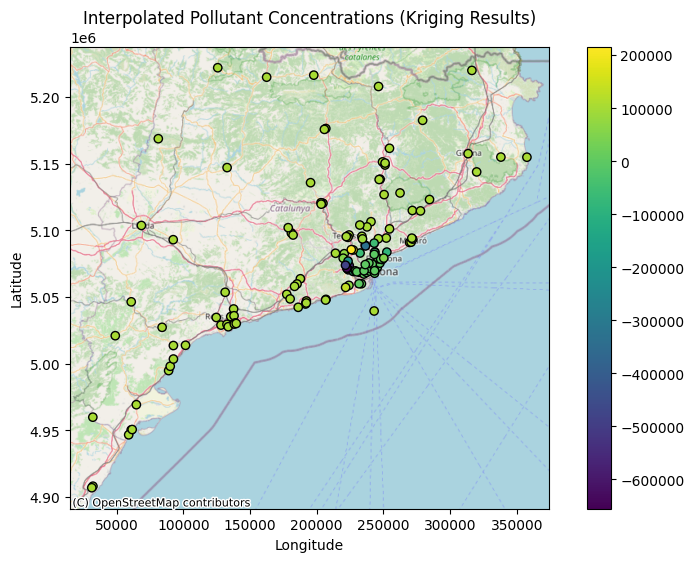

In [37]:
############################################################
# Step 4: Visualizar resultados en un mapa
############################################################

# Convertir las geometrías al CRS Web Mercator para agregar un mapa base
sp_obs_locations_webmercator = sp_obs_locations.to_crs(epsg=3857)

# Crear un gráfico para mostrar los resultados
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sp_obs_locations_webmercator.plot(
    column='kriging_prediction',
    ax=ax,
    legend=True,
    cmap='viridis',
    edgecolor='k'
)

# Añadir un mapa base con Contextily
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Añadir título y etiquetas
ax.set_title('Interpolated Pollutant Concentrations (Kriging Results)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Mostrar el gráfico
plt.show()

In [38]:
############################################################
# Step 5: Crear un mapa interactivo con Folium
############################################################

# Convertir a WGS84 para usar con Folium
sp_obs_locations_wgs84 = sp_obs_locations.to_crs(epsg=4326)

# Extraer coordenadas para Folium
sp_obs_locations_wgs84['lon'] = sp_obs_locations_wgs84.geometry.x
sp_obs_locations_wgs84['lat'] = sp_obs_locations_wgs84.geometry.y

# Crear un colormap para los valores interpolados
norm = mcolors.Normalize(
    vmin=sp_obs_locations_wgs84['kriging_prediction'].min(),
    vmax=sp_obs_locations_wgs84['kriging_prediction'].max()
)
cmap = plt.cm.viridis

# Crear un mapa base centrado en los datos
map_center = [
    sp_obs_locations_wgs84['lat'].mean(),
    sp_obs_locations_wgs84['lon'].mean()
]
m = folium.Map(location=map_center, zoom_start=12)

# Añadir marcadores circulares para cada estación de observación
for idx, row in sp_obs_locations_wgs84.iterrows():
    color = mcolors.to_hex(cmap(norm(row['kriging_prediction'])))
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=5,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=f"Pollutant: {row['kriging_prediction']:.2f}"
    ).add_to(m)

# Mostrar el mapa interactivo
m

In [ ]:
# Convertir geometrías al CRS WGS84 (EPSG:4326) para usar con Folium
sp_model_bcn_wgs84 = sp_model_bcn.to_crs(epsg=4326)
refined_grid_bcn_wgs84 = refined_grid_bcn.to_crs(epsg=4326)

# Crear un mapa centrado en el dominio de Barcelona
map_center = [
    sp_model_bcn_wgs84.geometry.centroid.y.mean(),
    sp_model_bcn_wgs84.geometry.centroid.x.mean()
]
m = folium.Map(location=map_center, zoom_start=12)

# Añadir puntos de sp_model_bcn al mapa
for idx, row in sp_model_bcn_wgs84.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=3,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        popup=f"Pollutant: {row['pollutant']:.2f}"
    ).add_to(m)

# Añadir las celdas de refined_grid_bcn al mapa con colores basados en una estadística
# Ejemplo: asignar color por un atributo como 'pollutant_mean'
if 'pollutant_mean' in refined_grid_bcn_wgs84.columns:
    # Crear un colormap
    norm = mcolors.Normalize(
        vmin=refined_grid_bcn_wgs84['pollutant_mean'].min(),
        vmax=refined_grid_bcn_wgs84['pollutant_mean'].max()
    )
    cmap = plt.cm.viridis

    # Dibujar las celdas con colores
    for _, row in refined_grid_bcn_wgs84.iterrows():
        color = mcolors.to_hex(cmap(norm(row['pollutant_mean'])))
        folium.GeoJson(
            row.geometry,
            style_function=lambda x, color=color: {
                'fillColor': color,
                'color': 'black',
                'weight': 0.5,
                'fillOpacity': 0.5
            },
            tooltip=f"Mean Pollutant: {row['pollutant_mean']:.2f}"  # Mostrar el valor en un tooltip
        ).add_to(m)

# Guardar el mapa como HTML (opcional) y mostrarlo
#m.save('map_sp_model_bcn.html')
m


C:\Users\weiha\AppData\Local\Temp\ipykernel_25752\62453977.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sp_model_bcn_wgs84.geometry.centroid.y.mean(),
C:\Users\weiha\AppData\Local\Temp\ipykernel_25752\62453977.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sp_model_bcn_wgs84.geometry.centroid.x.mean()
